# 📁 04 - Model Training & Evaluation

### 🎯 Objective  
Train, validate, and evaluate regression models to predict the target variable (`stress_score`) using the reduced feature set generated during the feature selection phase.

This notebook serves as the final step in the experimentation pipeline before transitioning to production-level code and automation.

---

### 🧩 Key Steps

1. **Load Selected Features**  
   - Import the lightweight dataset (`data-for-model.csv`) containing only relevant variables.

2. **Train/Test Split**  
   - Use a fixed holdout strategy (e.g., keep as test set the last three months of data) to simulate real-world forecasting.
   - Explore TimeSeriesSplit for cross-validation robustness.

3. **Model Training**  
   - Test different regression models:
     - XGBoost Regressor
     - Artificial Neural Networks (ANN)
     - LSTM (Long Short Term Memory)

4. **Hyperparameter Tuning**  
   - Apply `RandomizedSearchCV` for optimized model configuration (XGB).

5. **Evaluation Metrics**  
   - Compute **RMSE** on the test set.
   - Compare results between models.

---

### 🛠️ Output
- Evaluation scores for all models.
- Plots comparing real vs predicted values.
- Insights about model behavior and generalization ability.

---

> 📝 Note:  
> This notebook focuses on **offline training and experimentation**. In a production scenario, these steps would be modularized into scripts, pipelines, or jobs orchestrated by MLOps tools.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor

#Ignore warnings in order to have a cleaner output
import warnings
warnings.filterwarnings('ignore')
#Suppress scientific notation
np.set_printoptions(suppress=True)

In [66]:
data = pd.read_csv('../data/processed/data-for-model.csv', sep=',')

In [67]:
# Train-test split => Here we use rolling windows strategy on train 
# and we will keep always the last 90 days (around the last 3 months) of the data as test set:

#Format again becuase lose when we saved it.
data['date'] = pd.to_datetime(data['date'])

cutoff_date = data['date'].max() - pd.Timedelta(days=90)

X_train = data[data['date'] < cutoff_date]
y_train = X_train['stress_score']
X_train.drop(columns=['stress_score'], inplace=True)

X_test = data[data['date'] >= cutoff_date]
y_test = X_test['stress_score']
X_test.drop(columns=['stress_score'], inplace=True)

In [ ]:
#After that, we can safety drop it:
X_train.drop(columns='date', inplace=True)
X_test.drop(columns='date', inplace=True)

In [ ]:
# tscv only uses the row order (index positions) in your dataset to create splits, not the actual date values.
tscv = TimeSeriesSplit()

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'gamma': [5, 6, 7, 8], # Same as min_split_loss
    'reg_alpha':[1, 3, 5, 7], #L1 Regularization
    'reg_lambda': [0.1, 0.5, 3, 5] #L2 Regularization
}

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'gamma': [5, 6, ...], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [2, 4, ...], 'n_estimators': [50, 100, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [6]:
bestXGB = search.best_estimator_

In [13]:
preds = bestXGB.predict(X_test)

In [14]:
print(f'RMSE of XGB Regressor (Tuned): {np.round(root_mean_squared_error(y_test,preds), 2)}')

RMSE of XGB Regressor (Tuned): 113.69


In [ ]:
# index=y_test.index it's better than y_test.reset_index(drop=True) because in this way
# matches the index and you don't lose information of y_test
preds = pd.Series(preds, index=y_test.index)

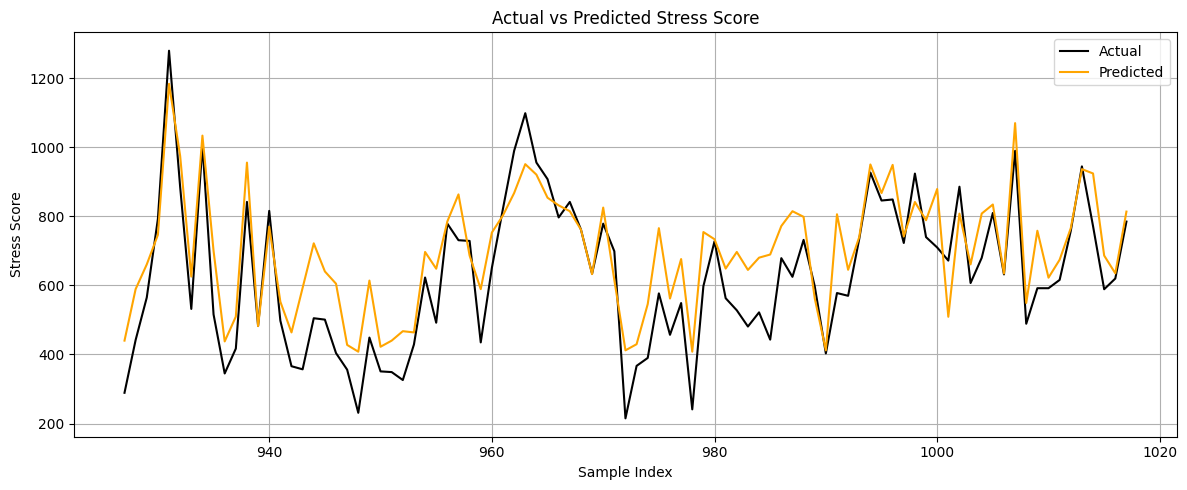

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', color='black')
plt.plot(preds, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stress Score')
plt.xlabel('Sample Index')
plt.ylabel('Stress Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# What if we predict with the default XGBoost?
xgb.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
# xgb.predict(X_test) returns np.ndarray so I wrapped it in one line of code
preds = pd.Series(xgb.predict(X_test), index=y_test.index)

In [20]:
print(f'RMSE of XGB Regressor (Default): {np.round(root_mean_squared_error(y_test,preds), 2)}')

RMSE of XGB Regressor (Default): 105.73


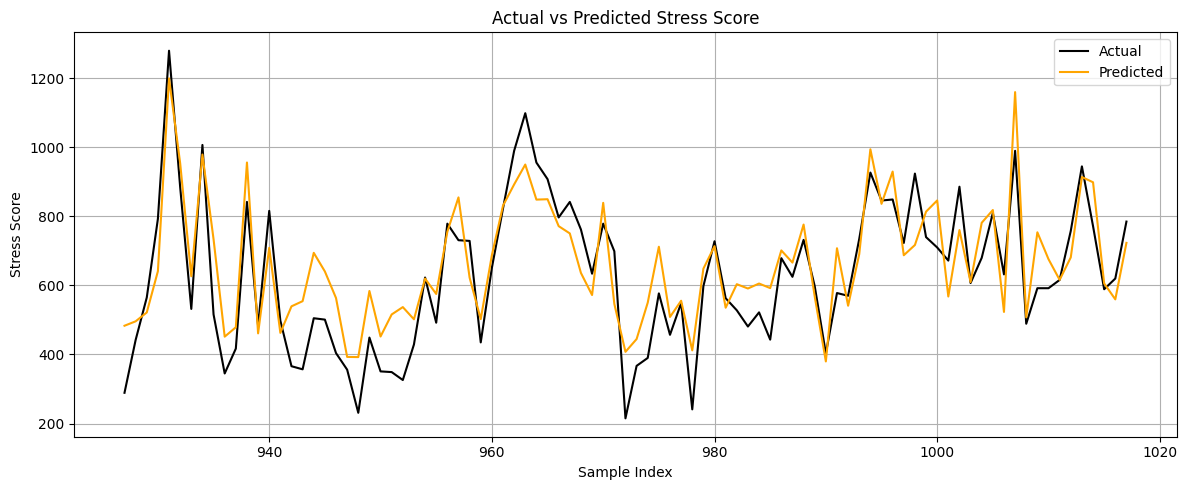

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', color='black')
plt.plot(preds, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stress Score')
plt.xlabel('Sample Index')
plt.ylabel('Stress Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Note from docs: Coefficients are defined only for linear learners

Coefficients are only defined when the linear model is chosen as base learner (booster=gblinear). It is not defined for other base learner types, such as tree learners (booster=gbtree). 
You can explore a better grid finding each default value parameter and then tunning accordingly. 

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Scale your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 621578.5000 - mae: 763.7776 - val_loss: 697119.6250 - val_mae: 802.6096
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 650315.6875 - mae: 772.6455 - val_loss: 693034.8750 - val_mae: 800.3474
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 645713.8750 - mae: 775.3679 - val_loss: 686317.3750 - val_mae: 796.6788
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 606596.8125 - mae: 750.2519 - val_loss: 676526.8750 - val_mae: 791.3390
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 596375.1875 - mae: 744.5394 - val_loss: 662871.8125 - val_mae: 783.9149
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 598517.1875 - mae: 745.4164 - val_loss: 644634.5000 - val_mae: 773.8917
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 572716.6250 - mae: 732.3740 - val_loss: 622248.0625 - val_mae: 761.2953
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 521775.9375 - mae: 697.1567 - va

In [31]:
preds = pd.Series(model.predict(X_test_scaled).reshape(-1), index=y_test.index)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [32]:
print(f'RMSE of ANN: {np.round(root_mean_squared_error(y_test,preds), 2)}')

RMSE of ANN: 162.74


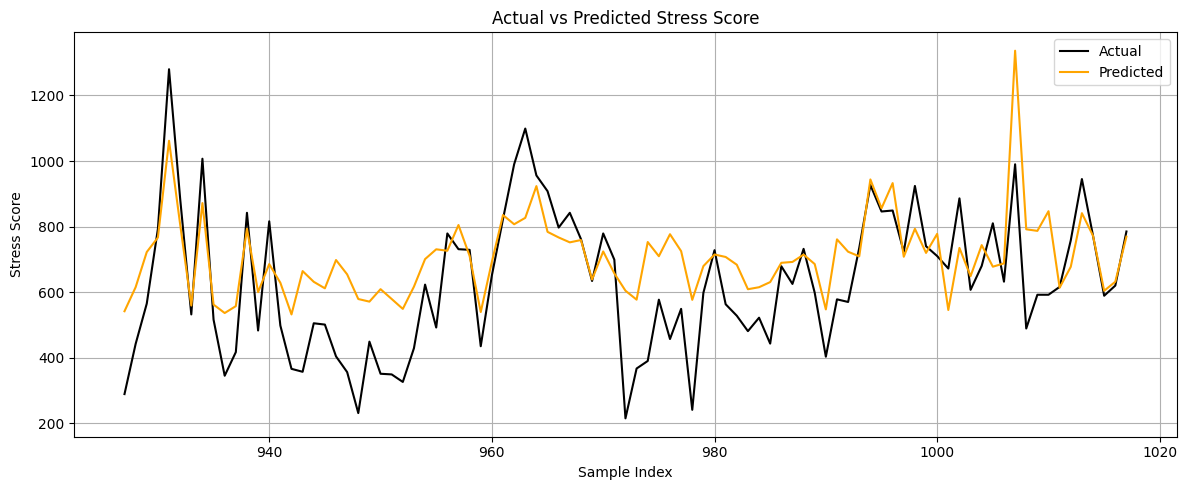

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', color='black')
plt.plot(preds, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stress Score')
plt.xlabel('Sample Index')
plt.ylabel('Stress Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
# Normalize the Data
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_train)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))


In [70]:
# Create Sliding Windows

WINDOW_SIZE = 7

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, WINDOW_SIZE)

print(X_seq.shape)  # (samples, window_size, n_features)
print(y_seq.shape)  # (samples, 1)


(920, 7, 9)
(920, 1)


In [71]:
# Train/Test Split
split_index = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

In [72]:
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Regression output

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0113 - val_loss: 0.0089
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0103
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0103
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0095
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0097
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0094
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_loss: 0.0093
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_l

In [74]:
y_pred = model.predict(X_test)
y_pred_inverse = scaler_y.inverse_transform(y_pred)
y_test_inverse = scaler_y.inverse_transform(y_test)

rmse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"Test RMSE LSTM: {rmse:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test RMSE LSTM: 223.93


In [75]:
print(y_pred_inverse[:10])

[[ 829.92316]
 [ 816.3153 ]
 [ 797.43713]
 [1092.3438 ]
 [1016.5233 ]
 [ 848.7656 ]
 [ 841.4706 ]
 [1035.899  ]
 [1111.2036 ]
 [1036.7196 ]]


In [76]:
print(y_test[:10])

[[0.22424512]
 [0.26376554]
 [0.68383659]
 [0.27797513]
 [0.40008881]
 [0.34280639]
 [0.45692718]
 [0.34369449]
 [0.3401421 ]
 [0.40808171]]


In [77]:
print(y_test_inverse[:10])

[[ 811.]
 [ 900.]
 [1846.]
 [ 932.]
 [1207.]
 [1078.]
 [1335.]
 [1080.]
 [1072.]
 [1225.]]


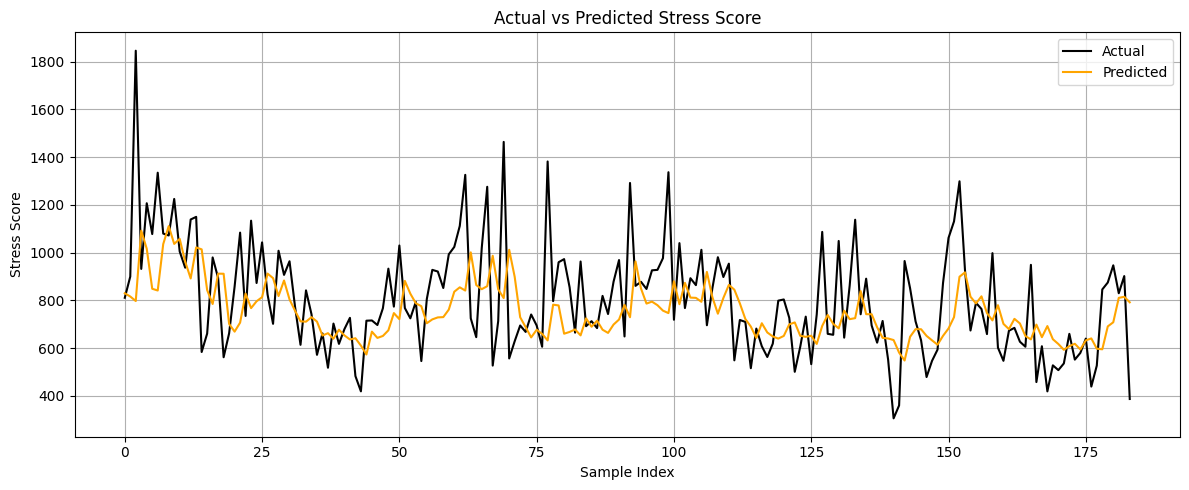

In [78]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inverse, label='Actual', color='black')
plt.plot(y_pred_inverse, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stress Score')
plt.xlabel('Sample Index')
plt.ylabel('Stress Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Some values in y_test may appear mismatched compared to the original target range. This is expected behavior because the MinMaxScaler was fitted only on the training set (to prevent data leakage). As a result, if the test set contains values outside the training range (e.g., large spikes), the inverse transform can produce distortions or exaggerate the scale.